### This notebook is for illustrating lick sensor data upon slow and binge eating.
#### tasks:
#### - [x] Load phenosys csv files, convert date time to seconds
#### - [x] Load lick sensor activation time, adding missing values
#### - [ ] perform cleaning (removed motor caused activation)
#### - [ ] Calculate licks and separate them into slow and binge eating bouts

In [1]:
## import functions

import sys
sys.path.append('/Users/hunglo/Documents/python_codes/')
from IO_ import load_csv_files


In [2]:
## import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pynapple as nap
from os import listdir
from os.path import isfile, join

%matplotlib inline
%config InlineBackend.figure_format = 'svg' ## disable for now, too bulky for all the individual plots
# %config InlineBackend.figure_format = 'retina'

## create color map
my_color_map = ['#56b4e9',
                '#e69f00',
                '#009e73',
                '#f0e442',
                '#0072b2',
                '#d55e00',
                '#cc79a7']

## font setting
plt.rcParams["font.family"] = 'Arial'
plt.rcParams.update({'font.size': 8})

my_color_map = sns.color_palette(my_color_map)

# def get_auto_colors(n_mice):
#     auto_color_map_cat = sns.color_palette("husl", n_mice)
#     return auto_color_map_cat


In [9]:
## functions

def load_id(file_path):
    mouse_id = file_path.split('_opto_')[0].split('/')[-1]
    print(mouse_id)
    date = file_path.split('_Inscopix-')[1].split('_')[0]
    date = date.replace('.','')
    print(date)

    return mouse_id, date
    
def load_data(file_path):

    L1_timestamps, L2_timestamps, all_lick_events = load_csv_files.lick_event_calculate(csv_path=file_path)
    P1_time, P1C_time, P2_time, P2A_time, pump_all = load_csv_files.GPIO_event_calculate(csv_path=file_path)
    L1_timestamps,L2_timestamps,P1_time, P1C_time, P2_time, P2A_time = load_csv_files.remove_exceeding_timepoint(L1_timestamps,L2_timestamps,P1_time, P1C_time, P2_time, P2A_time,time=3600)
    L1_timestamps = load_csv_files.select_lick_sensor(L1_timestamps, L2_timestamps)
    Pump1, Pump2 = load_csv_files.select_opto_pump_led(P1_time, P1C_time, P2_time, P2A_time)
    Pump1_new,Pump2_new,Pump_all_no_init = load_csv_files.remove_pheno_init_opto(Pump1,Pump2)

    L1_timestamps_new = load_csv_files.add_missing_licks(Pump1_new,L1_timestamps) ## notice I used Pump1_new, not Pump_all_no_init, since Pump2 data is not actually related to lick events

    ## baseline finish time
    baseline_finish_time = load_csv_files.baseline_finish_time(file_path)

    return L1_timestamps_new,Pump1_new,Pump2_new,baseline_finish_time

def plot_lick_pump_LED_events(L1_timestamps_new,Pump1_new,Pump2_new,baseline_finish_time,draw_baseline = False,draw_interval = False):
    ## Viz pump & lick sensor data
    fig,axes = plt.subplots(figsize=[13,3.5],nrows=2,sharex=True,gridspec_kw={'height_ratios': [1, 2]})

    axes[1].eventplot([L1_timestamps_new,Pump1_new,Pump2_new],colors=['C3','C1','C0'],linelengths=0.8,linewidths=1)
    axes[1].legend([f'Licks n={len(L1_timestamps_new)}',f'Milk pump n={len(Pump1_new)}',f'LED n={len(Pump2_new)}'],loc=1,fontsize=8,frameon=False)

    licks = nap.Ts(L1_timestamps_new,time_units='s')
    axes[0].plot(licks.count(1))
    a = licks.count(1).values
    a_nozero = a[a != 0]
    axes[0].text(x=150,y=np.max(licks.count(1)),s=f'max={np.max(licks.count(1))}\nmedian={int(np.median(a_nozero))}',ha='center',va='center')

    axes[0].set_ylabel('lick rate (Hz)')
    axes[1].set_yticks([])
    axes[1].set_ylabel('time stamps')
    axes[1].set_xlabel('time (seconds)')

    axes[1].axvspan(xmin=0,xmax=300,alpha=0.2,color='C0')
    axes[1].axvspan(xmin=300,xmax=baseline_finish_time,alpha=0.2,color='C1')
    axes[1].text(x=150,y=2.5,s='Pump\ninactivated',va='top',ha='center')

    axes[0].set_title(f'Opto protocol: {LED_state}\n{mouse_id}_{date}')
    axes[1].axvline(x=baseline_finish_time,color='k',ls=':')
    axes[1].text(x=baseline_finish_time+10,y=2.75,s=f'{int(round(baseline_finish_time-300))} sec',va='bottom',ha='left')
    plt.xlim(xmin=-5)
    sns.despine()

    draw_baseline = False # change to True if you want to add arrows
    if draw_baseline:
        # axes[1].arrow(x=300+30,y=2.7,dx=-20,dy=0,head_width=0.15, head_length=5, fc='C0', ec='C0')
        # axes[1].arrow(x=baseline_finish_time-30,y=2.7,dx=20,dy=0,head_width=0.15, head_length=5, fc='C0', ec='C0')
        axes[1].plot([300,baseline_finish_time],[2.7,2.7])

    draw_interval = False
    if draw_interval:
        LED_intervals = Pump2_new[1:]-Pump2_new[:-1]
        for idx, inter_ in enumerate(LED_intervals):
            axes[1].text(x=Pump2_new[idx]+inter_/2,y=2.3,s=f'{int(round(inter_,))}',ha='center',va='center')
            # axes[1].plot([Pump2_new[idx],Pump2_new[idx+1]],[2.4,2.4],ls=':')
            axes[1].arrow(x=Pump2_new[idx]+10+5+2,y=2.3,dx=-10,dy=0,head_width=0.15, head_length=5, fc='C0', ec='C0')
            axes[1].arrow(x=Pump2_new[idx+1]-10-5-2,y=2.3,dx=10,dy=0,head_width=0.15, head_length=5, fc='C0', ec='C0')
        
    plt.tight_layout()

def plot_feeding_bout(Pump1_new,Pump2_new,feeding_epoch,df,mouse_id,date,LED_state):

    plt.figure(figsize=[13,3.5])
    plt.eventplot(Pump2_new,lineoffsets=2,linelengths=0.8,color='C0',label='LED')
    plt.eventplot(Pump1_new,linelengths=0.8,colors='C1',label='Milk pump')
    for i in range(df.shape[0]):
        if i ==0:
            plt.plot([df['LED'][i],df['binge_end'][i]],[2.5,2.5],color=my_color_map[i%7],label='Feeding duration since LED')
        else:
            plt.plot([df['LED'][i],df['binge_end'][i]],[2.5,2.5],color=my_color_map[i%7])
    for i in range(df.shape[0]):
        if i ==0:
            plt.plot(df['binge_end'][i],1.5,marker='.',color=my_color_map[i%7],ls='',label='Bout end after LED on')
        else:
            plt.plot(df['binge_end'][i],1.5,marker='.',color=my_color_map[i%7],ls='')

    for i in range(feeding_epoch.shape[0]):
        if i == 0:
            plt.plot([feeding_epoch['start'][i],feeding_epoch['end'][i]],[0.5,0.5],color=my_color_map[i%7],label=f'Feeding bout (gap <{interval}s)',lw=3)
        else:       
            plt.plot([feeding_epoch['start'][i],feeding_epoch['end'][i]],[0.5,0.5],color=my_color_map[i%7],lw=3)
    # plt.legend(['LED','Milk Pump','Binge biouts'])
    plt.legend(loc=1,frameon=False,fontsize=8)
    plt.ylim(ymax=4)
    plt.title(f'{mouse_id}_{date}_{LED_state}')
    plt.xlim(xmin=-5)
    sns.despine()
    plt.tight_layout()

# def detect_feeding_bout(Pump1,interval=3):
#     # if pump interval is less than 2 seconds?
#     Pump1 = np.pad(Pump1, (1, 0), 'constant', constant_values=(0,0))
#     diff = Pump1[1:]-Pump1[:-1]
#     gap = diff>interval # binary data
#     idx = np.where(gap == 1) # idx == 1
#     start_concat, end_concat = [],[]
#     for idx_ in idx:
#         start_concat.append(Pump1[idx_+1])
#         end_concat.append(Pump1[idx_])
#     start_concat = start_concat[0][:-1] # remove empty starting
#     end_concat = end_concat[0][1:] # remove empty ending
#     ## check if it's too short? should we add this?
    
#     return start_concat, end_concat

def detect_feeding_bout(Pump1,interval=3):
    Pump1 = np.pad(Pump1, (1, 1), 'constant', constant_values=(0,Pump1.max()+interval*10)) # so the last value is more than interval
    diff = Pump1[1:]-Pump1[:-1]
    gap = diff>interval # binary data
    idx = np.where(gap == 1) # idx == 1
    start_concat, end_concat = [],[]
    for idx_ in idx:
        start_concat.append(Pump1[1:][idx_])
        end_concat.append(Pump1[:][idx_])
    start_concat = start_concat[0][:-1] # remove empty starting
    end_concat = end_concat[0][1:] # remove empty ending

    # binge_epoch = nap.IntervalSet(start_concat,end_concat)

    # ## run through the rows to make sure there isn't no duration epochs
    # ## note this should be taken care of from the pynapple package but somehow it isn't working properly 
    # binge_epoch_clean = pd.DataFrame(data=[], columns=['start','end'])
    # for n in range(binge_epoch.shape[0]):
    #     for x,y in binge_epoch[n:n+1].values:
    #         # print(x,y)
    #         # if x!= y: ## this is the old alg
    #         # if y-x >interval:
    #         if True:
    #             binge_epoch_clean = pd.concat([binge_epoch_clean,binge_epoch[n:n+1]])
    # binge_epoch_clean = nap.IntervalSet(binge_epoch_clean['start'],binge_epoch_clean['end'], time_units='s')
    return start_concat, end_concat

def duration_after_LED(binge_epoch,Pump2_new):
    binge_start_list = []
    binge_end_list = []
    duration_list = []
    for time in Pump2_new:
        idx = binge_epoch['start'][binge_epoch['start']<time].index[-1] # find the last binge bout start before LED
        start_ = binge_epoch['start'][binge_epoch['start']<time].iloc[-1]
        ## get the binge end with the idx
        end_ = binge_epoch['end'][binge_epoch['start']<time].iloc[idx]

        if end_ > time: # if the binge bout stops after LED
            duration = end_ - time
            binge_start_list.append(start_)
            binge_end_list.append(end_)
            duration_list.append(duration)
        else:
            duration = 0 # assume mouse stopped right when the LED is triggered so the binge bout stopped before LED
            binge_start_list.append(start_)
            binge_end_list.append(end_)
            duration_list.append(duration)
        df = pd.DataFrame([Pump2_new,binge_start_list,binge_end_list,duration_list]).T
        df = df.rename(columns={0 : "LED",1:'binge_start',2:'binge_end',3:'duration'})
        df_2 = df.dropna()
        df_3 = df_2.drop_duplicates(subset="binge_end", keep='first')
        df_3.reset_index(inplace=True,drop=True)
    return df_3

def print_stats(feeding_epoch,df,Pump1_new,baseline_finish_time):

    total_feeding_time = (feeding_epoch['end']-feeding_epoch['start']).sum()
    total_post_LED_feeding_time = df['duration'].sum()
    mean_feeding_time = (feeding_epoch['end']-feeding_epoch['start']).mean()
    total_milk_consumption = len(Pump1_new)
    mean_post_LED_feeding_duration = df['duration'].mean()

    print(f'baseline finish time = {round(baseline_finish_time,2)} sec')
    print(f'total feeding time = {round(total_feeding_time,2)} sec')
    print(f'total post LED feeding time = {round(total_post_LED_feeding_time,2)} sec')
    print(f'total milk consumption = {total_milk_consumption} deliveries')
    print(f'# feeding bout = {feeding_epoch.shape[0]}')
    print(f'mean feeding bout duration = {round(mean_feeding_time,2)}')
    print(f'mean post LED feeding duration = {round(mean_post_LED_feeding_duration,2)}')

def return_stats(file_path,LED_on_date_list,interval):
    mouse_id, date = load_id(file_path) 
    L1_timestamps_new,Pump1_new,Pump2_new,baseline_finish_time = load_data(file_path)

    if date in LED_on_date_list:
        LED_state = 'LED on'
    else:
        LED_state = 'LED off'

    print(mouse_id)
    print(date)    
    print(LED_state)
    feed_start, feed_end = detect_feeding_bout(Pump1_new,interval=interval)
    feeding_epoch = nap.IntervalSet(feed_start,feed_end)
    df = duration_after_LED(feeding_epoch,Pump2_new)

    # print_stats(feeding_epoch,df,Pump1_new,baseline_finish_time)
    print('====================================================\n')

    return mouse_id, date, LED_state, L1_timestamps_new, Pump1_new, Pump2_new, feeding_epoch, df, baseline_finish_time


In [10]:
## All together

## Settings
interval = 3 ## sec, defined for when a feeding bout is discontinued and separated into a different feeding bout
LED_on_date_list = ['230106','230110','230112','230114','230117','230120','230221','230223','230225','230228','230302','230304']

file_folder = '/Users/hunglo/Documents/inscopix_csv/opto_csv/csv_folder/' # path where we have all the opto data in csv format
fig_output_folder = '/Users/hunglo/Documents/inscopix_csv/opto_csv/fig_output/'
file_path_list = [f for f in listdir(file_folder) if isfile(join(file_folder, f))]
file_path_list = sorted([f for f in file_path_list if '_.csv' in f])

show_plot = False

# create empty dict for holding each variables through the for loop
lick_dict = {}
milk_dict = {}
duration_dict = {}
duration_LED_dict = {}
Pump1_dict = {}
baseline_dict = {}


for file in file_path_list:
    file_path = join(file_folder,file)
    mouse_id, date, LED_state, L1_timestamps_new, Pump1_new, Pump2_new, feeding_epoch, df, baseline_finish_time = return_stats(file_path,LED_on_date_list,interval)
    if show_plot:
        plot_lick_pump_LED_events(L1_timestamps_new,Pump1_new,Pump2_new,baseline_finish_time,draw_baseline = False,draw_interval = False)
    lick_dict[f'{mouse_id}_{date}'] = L1_timestamps_new
    milk_dict[f'{mouse_id}_{date}'] = Pump1_new
    total_feeding_time = (feeding_epoch['end']-feeding_epoch['start']).sum()
    duration_dict[f'{mouse_id}_{date}'] = total_feeding_time
    total_post_LED_feeding_time = df['duration'].sum()
    duration_LED_dict[f'{mouse_id}_{date}'] = total_post_LED_feeding_time
    baseline_dict[f'{mouse_id}_{date}'] = baseline_finish_time - 300 # minus the 5 min no lick spouts baseline time
    
print('Done')

DSC019649
230105
File processed: DSC019649_opto_Inscopix-23.01.05_.csv
Is there any duplication?: False
DSC019649
230105
LED off

DSC019649
230106
File processed: DSC019649_opto_Inscopix-23.01.06_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019649
230106
LED on

DSC019649
230109
File processed: DSC019649_opto_Inscopix-23.01.09_.csv
Is there any duplication?: False
DSC019649
230109
LED off

DSC019649
230110
File processed: DSC019649_opto_Inscopix-23.01.10_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019649
230110
LED on

DSC019649
230111
File processed: DSC019649_opto_Inscopix-23.01.11_.csv
Is there any duplication?: False
DSC019649
230111
LED off

DSC019649
230112
File processed: DSC019649_opto_Inscopix-23.01.12_.csv
Is there any duplication?: False
DSC019649
230112
LED on


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC019649
230113
File processed: DSC019649_opto_Inscopix-23.01.13_.csv
Is there any duplication?: False
DSC019649
230113
LED off

DSC019649
230114
File processed: DSC019649_opto_Inscopix-23.01.14_.csv
Is there any duplication?: False
DSC019649
230114
LED on

DSC019649
230116
File processed: DSC019649_opto_Inscopix-23.01.16_.csv
Is there any duplication?: False
DSC019649
230116
LED off

DSC019649
230117
File processed: DSC019649_opto_Inscopix-23.01.17_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019649
230117
LED on

DSC019649
230119
File processed: DSC019649_opto_Inscopix-23.01.19_.csv
Is there any duplication?: False
DSC019649
230119
LED off

DSC019649
230120
File processed: DSC019649_opto_Inscopix-23.01.20_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019649
230120
LED on

DSC019650
230105
File processed: DSC019650_opto_Inscopix-23.01.05_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019650
230105
LED off

DSC019650
230106
File processed: DSC019650_opto_Inscopix-23.01.06_.csv
Is there any duplication?: False
DSC019650
230106
LED on

DSC019650
230109
File processed: DSC019650_opto_Inscopix-23.01.09_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019650
230109
LED off

DSC019650
230110
File processed: DSC019650_opto_Inscopix-23.01.10_.csv
Is there any duplication?: False
DSC019650
230110
LED on


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC019650
230111
File processed: DSC019650_opto_Inscopix-23.01.11_.csv
Is there any duplication?: False
DSC019650
230111
LED off


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC019650
230112
File processed: DSC019650_opto_Inscopix-23.01.12_.csv
Is there any duplication?: False
DSC019650
230112
LED on

DSC019650
230113
File processed: DSC019650_opto_Inscopix-23.01.13_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019650
230113
LED off

DSC019650
230114
File processed: DSC019650_opto_Inscopix-23.01.14_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019650
230114
LED on

DSC019650
230116
File processed: DSC019650_opto_Inscopix-23.01.16_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019650
230116
LED off

DSC019650
230117
File processed: DSC019650_opto_Inscopix-23.01.17_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019650
230117
LED on

DSC019650
230119
File processed: DSC019650_opto_Inscopix-23.01.19_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019650
230119
LED off

DSC019650
230120
File processed: DSC019650_opto_Inscopix-23.01.20_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019650
230120
LED on

DSC019651
230220
File processed: DSC019651_opto_Inscopix-23.02.20_.csv
Is there any duplication?: False
DSC019651
230220
LED off


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC019651
230221
File processed: DSC019651_opto_Inscopix-23.02.21_.csv
Is there any duplication?: False
DSC019651
230221
LED on

DSC019651
230222


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


File processed: DSC019651_opto_Inscopix-23.02.22_.csv
Is there any duplication?: False
DSC019651
230222
LED off


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC019651
230223
File processed: DSC019651_opto_Inscopix-23.02.23_.csv
Is there any duplication?: False
DSC019651
230223
LED on

DSC019651
230224
File processed: DSC019651_opto_Inscopix-23.02.24_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019651
230224
LED off

DSC019651
230225
File processed: DSC019651_opto_Inscopix-23.02.25_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019651
230225
LED on

DSC019651
230227
File processed: DSC019651_opto_Inscopix-23.02.27_.csv
Is there any duplication?: False
DSC019651
230227
LED off


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC019651
230228
File processed: DSC019651_opto_Inscopix-23.02.28_.csv
Is there any duplication?: False
DSC019651
230228
LED on

DSC019651
230301
File processed: DSC019651_opto_Inscopix-23.03.01_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019651
230301
LED off

DSC019651
230302
File processed: DSC019651_opto_Inscopix-23.03.02_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019651
230302
LED on

DSC019651
230303
File processed: DSC019651_opto_Inscopix-23.03.03_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019651
230303
LED off

DSC019651
230304
File processed: DSC019651_opto_Inscopix-23.03.04_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC019651
230304
LED on

DSC019652
230220
File processed: DSC019652_opto_Inscopix-23.02.20_.csv
Is there any duplication?: False
DSC019652
230220
LED off

DSC019652
230221


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


File processed: DSC019652_opto_Inscopix-23.02.21_.csv
Is there any duplication?: False
DSC019652
230221
LED on

DSC019652
230222
File processed: DSC019652_opto_Inscopix-23.02.22_.csv
Is there any duplication?: False
DSC019652
230222
LED off


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC019652
230223
File processed: DSC019652_opto_Inscopix-23.02.23_.csv
Is there any duplication?: False
DSC019652
230223
LED on


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC019652
230224
File processed: DSC019652_opto_Inscopix-23.02.24_.csv
Is there any duplication?: False
DSC019652
230224
LED off

DSC019652
230225
File processed: DSC019652_opto_Inscopix-23.02.25_.csv
Is there any duplication?: False
DSC019652
230225
LED on


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC019652
230227
File processed: DSC019652_opto_Inscopix-23.02.27_.csv
Is there any duplication?: False
DSC019652
230227
LED off

DSC019652
230228
File processed: DSC019652_opto_Inscopix-23.02.28_.csv
Is there any duplication?: False
DSC019652
230228
LED on

DSC019652
230301


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


File processed: DSC019652_opto_Inscopix-23.03.01_.csv
Is there any duplication?: False
DSC019652
230301
LED off

DSC019652
230302
File processed: DSC019652_opto_Inscopix-23.03.02_.csv
Is there any duplication?: False
DSC019652
230302
LED on

DSC019652
230303


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


File processed: DSC019652_opto_Inscopix-23.03.03_.csv
Is there any duplication?: False
DSC019652
230303
LED off

DSC019652
230304


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


File processed: DSC019652_opto_Inscopix-23.03.04_.csv
Is there any duplication?: False
DSC019652
230304
LED on


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC020160
230220
File processed: DSC020160_opto_Inscopix-23.02.20_.csv
Is there any duplication?: False
DSC020160
230220
LED off

DSC020160
230221
File processed: DSC020160_opto_Inscopix-23.02.21_.csv
Is there any duplication?: False
DSC020160
230221
LED on

DSC020160
230222
File processed: DSC020160_opto_Inscopix-23.02.22_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020160
230222
LED off

DSC020160
230223
File processed: DSC020160_opto_Inscopix-23.02.23_.csv
Is there any duplication?: True
DSC020160
230223
LED on


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC020160
230224
File processed: DSC020160_opto_Inscopix-23.02.24_.csv
Is there any duplication?: False
DSC020160
230224
LED off


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC020160
230225
File processed: DSC020160_opto_Inscopix-23.02.25_.csv
Is there any duplication?: False
DSC020160
230225
LED on

DSC020160
230227
File processed: DSC020160_opto_Inscopix-23.02.27_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020160
230227
LED off

DSC020160
230228
File processed: DSC020160_opto_Inscopix-23.02.28_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020160
230228
LED on

DSC020160
230301


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


File processed: DSC020160_opto_Inscopix-23.03.01_.csv
Is there any duplication?: False
DSC020160
230301
LED off


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC020160
230302
File processed: DSC020160_opto_Inscopix-23.03.02_.csv
Is there any duplication?: False
DSC020160
230302
LED on

DSC020160
230303
File processed: DSC020160_opto_Inscopix-23.03.03_.csv
Is there any duplication?: False
DSC020160
230303
LED off

DSC020160
230304
File processed: DSC020160_opto_Inscopix-23.03.04_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020160
230304
LED on

DSC020161
230220
File processed: DSC020161_opto_Inscopix-23.02.20_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020161
230220
LED off

DSC020161
230221
File processed: DSC020161_opto_Inscopix-23.02.21_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020161
230221
LED on

DSC020161
230222
File processed: DSC020161_opto_Inscopix-23.02.22_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020161
230222
LED off

DSC020161
230223
File processed: DSC020161_opto_Inscopix-23.02.23_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020161
230223
LED on

DSC020161
230224
File processed: DSC020161_opto_Inscopix-23.02.24_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020161
230224
LED off

DSC020161
230225
File processed: DSC020161_opto_Inscopix-23.02.25_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020161
230225
LED on

DSC020161
230227
File processed: DSC020161_opto_Inscopix-23.02.27_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020161
230227
LED off

DSC020161
230228
File processed: DSC020161_opto_Inscopix-23.02.28_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020161
230228
LED on

DSC020161
230301
File processed: DSC020161_opto_Inscopix-23.03.01_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020161
230301
LED off

DSC020161
230302
File processed: DSC020161_opto_Inscopix-23.03.02_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020161
230302
LED on

DSC020161
230303
File processed: DSC020161_opto_Inscopix-23.03.03_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020161
230303
LED off

DSC020161
230304
File processed: DSC020161_opto_Inscopix-23.03.04_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020161
230304
LED on

DSC020469
230220
File processed: DSC020469_opto_Inscopix-23.02.20_.csv
Is there any duplication?: False
DSC020469
230220
LED off


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC020469
230221
File processed: DSC020469_opto_Inscopix-23.02.21_.csv
Is there any duplication?: False
DSC020469
230221
LED on

DSC020469
230222
File processed: DSC020469_opto_Inscopix-23.02.22_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020469
230222
LED off

DSC020469
230223
File processed: DSC020469_opto_Inscopix-23.02.23_.csv
Is there any duplication?: False
DSC020469
230223
LED on

DSC020469
230224


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


File processed: DSC020469_opto_Inscopix-23.02.24_.csv
Is there any duplication?: False
DSC020469
230224
LED off

DSC020469
230225
File processed: DSC020469_opto_Inscopix-23.02.25_.csv
Is there any duplication?: False
DSC020469
230225
LED on

DSC020469
230227
File processed: DSC020469_opto_Inscopix-23.02.27_.csv
Is there any duplication?: False
DSC020469
230227
LED off

DSC020469
230228
File processed: DSC020469_opto_Inscopix-23.02.28_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020469
230228
LED on

DSC020469
230301
File processed: DSC020469_opto_Inscopix-23.03.01_.csv
Is there any duplication?: False
DSC020469
230301
LED off

DSC020469
230302
File processed: DSC020469_opto_Inscopix-23.03.02_.csv
Is there any duplication?: True


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020469
230302
LED on

DSC020469
230303
File processed: DSC020469_opto_Inscopix-23.03.03_.csv
Is there any duplication?: False
DSC020469
230303
LED off

DSC020469
230304


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


File processed: DSC020469_opto_Inscopix-23.03.04_.csv
Is there any duplication?: False
DSC020469
230304
LED on

DSC020470
230220
File processed: DSC020470_opto_Inscopix-23.02.20_.csv
Is there any duplication?: False
DSC020470
230220
LED off


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC020470
230221
File processed: DSC020470_opto_Inscopix-23.02.21_.csv
Is there any duplication?: False
DSC020470
230221
LED on

DSC020470
230222
File processed: DSC020470_opto_Inscopix-23.02.22_.csv
Is there any duplication?: False


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


DSC020470
230222
LED off

DSC020470
230223
File processed: DSC020470_opto_Inscopix-23.02.23_.csv
Is there any duplication?: False
DSC020470
230223
LED on


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC020470
230224
File processed: DSC020470_opto_Inscopix-23.02.24_.csv
Is there any duplication?: False
DSC020470
230224
LED off

DSC020470
230225
File processed: DSC020470_opto_Inscopix-23.02.25_.csv
Is there any duplication?: False
DSC020470
230225
LED on

DSC020470
230227
File processed: DSC020470_opto_Inscopix-23.02.27_.csv
Is there any duplication?: False
DSC020470
230227
LED off


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC020470
230228
File processed: DSC020470_opto_Inscopix-23.02.28_.csv
Is there any duplication?: False
DSC020470
230228
LED on


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC020470
230301
File processed: DSC020470_opto_Inscopix-23.03.01_.csv
Is there any duplication?: False
DSC020470
230301
LED off


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC020470
230302
File processed: DSC020470_opto_Inscopix-23.03.02_.csv
Is there any duplication?: False
DSC020470
230302
LED on

DSC020470
230303
File processed: DSC020470_opto_Inscopix-23.03.03_.csv
Is there any duplication?: False
DSC020470
230303
LED off


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC020470
230304
File processed: DSC020470_opto_Inscopix-23.03.04_.csv
Is there any duplication?: False
DSC020470
230304
LED on

Done


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


In [11]:
## get data from dict and organize them into pd.DataFrame

keys = sorted(milk_dict.keys())

## If you only want to check one mouse then use the follow code:
# mouse_id = 'DSC019649'
# select_key = [key for key in keys if mouse_id in key]

select_key = keys

df_list = [] # a list to hold all pd.DataFrame

# also get lick data
for key in select_key:
    mouse_id = key.split('_')[0]
    date = key.split('_')[-1]
    if date in LED_on_date_list:
        LED_state = 'LED on'
    else:
        LED_state = 'LED off'
    milk_pump = milk_dict.get(key)
    milk_consumption = len(milk_dict.get(key))
    licks = len(lick_dict.get(key))
    duration = duration_dict.get(key)
    duration_LED = duration_LED_dict.get(key) 
    baseline_finish_time = baseline_dict.get(key)
    df_ = pd.DataFrame([mouse_id,date,LED_state,milk_consumption,licks,duration,duration_LED,milk_pump,baseline_finish_time])
    df_list.append(df_)

## Convert list to a large dataframe

df_concat = pd.DataFrame([np.zeros(df_.shape[0])]).T
for i in range(len(df_list)):
    df_concat = pd.concat([df_concat,df_list[i]],axis=1)

df_concat = df_concat.iloc[:,1:]
df_concat = df_concat.T
df_concat = df_concat.rename(columns={0 : "mouse_id",1:'date',2:'LED state',3:'milk consumption',4:'lick',5:'feeding duration',6:'feeding duration after closed-loop trigger',7:'milk pump',8:'baseline time'}).reset_index(drop=True)

## Add additional info to the dataframe

## add session number
## this is assumed that the order of these files are sorted with mouse ids, so make sure this is the case. (should be fine here)

day_list = []
for mouse_id in df_concat['mouse_id'].unique():
    df_short = df_concat[df_concat['mouse_id']==mouse_id]
    day_list_temp = []
    for date in df_short['date']:
        for idx,_ in enumerate(sorted(df_short['date'].unique())):
            if date == _:
                day_list_temp.append(int(idx+1))
    day_list.append(day_list_temp)
day_list = [i for sublist in day_list for i in sublist]
df_concat['session']=day_list
## also convert date to int for future merging
df_concat['date'] = df_concat['date'].astype(int)

## add viral type here
eOPN3_list = ['DSC019649','DSC019650','DSC019651','DSC019652']
viral_list = []
for idx,mouse_id in enumerate(df_concat['mouse_id']):
    if mouse_id in eOPN3_list:
        viral_list.append('1_eOPN3') # prefix here is just to force control to be 0 and opto to be 1, so the mixed model later is easier to interpret
    else:
        viral_list.append('0_tdTomato')
df_concat['virus']=viral_list


## add sex info here
female_list = ['DSC019651','DSC019652','DSC020469','DSC020470']
sex_list = []
for idx,mouse_id in enumerate(df_concat['mouse_id']):
    if mouse_id in female_list:
        sex_list.append('Female')
    else:
        sex_list.append('Male')
df_concat['sex']=sex_list

## Note that body weight info is stored separately, will add in the last cell before saving the csv file



In [12]:
def cumulative_plots(df_select,virus_type):
    t_led_on_mouse = []
    t_led_off_mouse = []

    for n, mouse_id in enumerate(df_select['mouse_id'].unique()):
        # add a new subplot iteratively
        ax = plt.subplot(1, len(df_select['mouse_id'].unique())+1, n + 1)
        i_on, i_off = 0, 0
        t_led_on, t_led_off = [], []

        for idx,date in enumerate(df_select[df_select['mouse_id']==mouse_id]['date']):
            if str(date) in LED_on_date_list:
                t = df_select[df_select['mouse_id']==mouse_id].iloc[idx]['milk pump']
                t_led_on.append(t)
                i_on+=1
            else:
                t = df_select[df_select['mouse_id']==mouse_id].iloc[idx]['milk pump']
                t_led_off.append(t)
                i_off+=1

        ## plot average line for each mouse subplot
        ## plot the avg line first so legend is with full colors, not the transparent ones
        if t_led_on !=[]:
            t_led_on_flat = sorted(np.concatenate(t_led_on).ravel())
            ax.plot(t_led_on_flat,np.array(range(1,len(t_led_on_flat)+1))/i_on,c=my_color_map[1],lw=2)
        else:
            pass
        t_led_off_flat = sorted(np.concatenate(t_led_off).ravel())
        ax.plot(t_led_off_flat,np.array(range(1,len(t_led_off_flat)+1))/i_off,c=my_color_map[0],lw=2)

        for t in t_led_on:
            ax.plot(t,range(1,len(t)+1),c=my_color_map[1],alpha=0.25,lw=1)
        for t in t_led_off:
            ax.plot(t,range(1,len(t)+1),c=my_color_map[0],alpha=0.25,lw=1)

        ax.legend([f'LED on: {i_on}',f'LED off: {i_off}'],frameon=False,loc=4)
        ax.set_title(f'{mouse_id}')
        ax.set_xlabel('Time (sec)')
        ax.set_ylabel('Cum. milk consumption')
        sns.despine(ax=ax)
        # ax.set_ylim([-10,510])

    # plot all trial together in last subplot
    ax = plt.subplot(1, len(df_select['mouse_id'].unique())+1, n + 2)
    i_on = 0
    i_off = 0
    for idx,date in enumerate(df_select['date']):
        if str(date) in LED_on_date_list:
            t = df_select.iloc[idx]['milk pump']
            i_on+=1
        else:
            t = df_select.iloc[idx]['milk pump']
            i_off+=1

    i_on, i_off = 0, 0
    t_led_on, t_led_off = [], []

    # plot average line
    for idx,date in enumerate(df_select['date']):
        if str(date) in LED_on_date_list:
            t_led_on.append(df_select.iloc[idx]['milk pump'])
            i_on+=1
        else:
            t_led_off.append(df_select.iloc[idx]['milk pump'])
            i_off+=1
    if t_led_on !=[]:
        t_led_on_flat = sorted(np.concatenate(t_led_on).ravel())
        ax.plot(t_led_on_flat,np.array(range(1,len(t_led_on_flat)+1))/i_on,c=my_color_map[1],lw=2)
    t_led_off_flat = sorted(np.concatenate(t_led_off).ravel())    
    ax.plot(t_led_off_flat,np.array(range(1,len(t_led_off_flat)+1))/i_off,c=my_color_map[0],lw=2)
    ax.legend([f'LED on: {i_on}',f'LED off: {i_off}'],frameon=False,loc=4)

    # plot individual lines
    for t in t_led_on:
        ax.plot(t,range(1,len(t)+1),c=my_color_map[1],alpha=0.25)

    for t in t_led_off:
        ax.plot(t,range(1,len(t)+1),c=my_color_map[0],alpha=0.25)
    
    ax.set_title(f'All trials')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Cum. milk consumption')
    sns.despine(ax=ax)
    # ax.set_ylim([-10,510])


In [13]:
def cumulative_plots_norm(df_select,virus_type):

    t_led_on_mouse = []
    led_off_max_mouse = []
    t_led_off_mouse = []

    for n, mouse_id in enumerate(df_select['mouse_id'].unique()):
        # add a new subplot iteratively
        ax = plt.subplot(1, len(df_select['mouse_id'].unique())+1, n + 1)
        i_on, i_off = 0, 0
        t_led_on, t_led_off = [], []

        for idx,date in enumerate(df_select[df_select['mouse_id']==mouse_id]['date']):
            if str(date) in LED_on_date_list:
                t = df_select[df_select['mouse_id']==mouse_id].iloc[idx]['milk pump']
                t_led_on.append(t)
                i_on+=1
            else:
                t = df_select[df_select['mouse_id']==mouse_id].iloc[idx]['milk pump']
                t_led_off.append(t)
                i_off+=1

        ## plot average line for each mouse subplot
        if t_led_on !=[]:
            t_led_on_flat = sorted(np.concatenate(t_led_on).ravel())
        else:
            pass
        t_led_off_flat = sorted(np.concatenate(t_led_off).ravel())

        ax.set_title(f'{mouse_id}')
        ax.set_xlabel('Time (sec)')
        ax.set_ylabel('Cum. milk consumption norm.')
        sns.despine(ax=ax)
        # ax.set_ylim([-10,510])

        ## normalize to LED off average max for each mouse and save for average plots
        led_off_max = np.max(np.array(range(1,len(t_led_off_flat)+1))/i_off)

        # shrink the y value (numbers of pump activations)
        # plot average LED on & LED off first, so the ax legend is more visible
        ax.plot(t_led_on_flat,np.array(range(1,len(t_led_on_flat)+1))/led_off_max/i_on,c=my_color_map[1],lw=2)
        ax.plot(t_led_off_flat,np.array(range(1,len(t_led_off_flat)+1))/led_off_max/i_off,c=my_color_map[0],lw=2)
        ax.legend([f'LED on: {i_on}',f'LED off: {i_off}'],frameon=False,loc=4)

        x_avg_on_mouse, y_avg_on_mouse = [],[]
        x_avg_off_mouse, y_avg_off_mouse = [],[]
        x_avg_on_mouse.append(t_led_on_flat)
        y_avg_on_mouse.append(np.array(range(1,len(t_led_on_flat)+1))/led_off_max/i_on)
        x_avg_off_mouse.append(t_led_off_flat)
        y_avg_off_mouse.append(np.array(range(1,len(t_led_off_flat)+1))/led_off_max/i_off)

        for t in t_led_on:
            ax.plot(t,np.array(range(1,len(t)+1))/led_off_max,c=my_color_map[1],lw=1,alpha=0.25)
        t_led_on_mouse.append(t_led_on)
        led_off_max_mouse.append(led_off_max)

        for t in t_led_off:
            ax.plot(t,np.array(range(1,len(t)+1))/led_off_max,c=my_color_map[0],lw=1,alpha=0.25)
        t_led_off_mouse.append(t_led_off)

    ## plot the normalized lines to the last subplot
    trial_num_on = len(t_led_on)*len(t_led_on_mouse)
    trial_num_off = len(t_led_off)*len(t_led_off_mouse)
    
    ## add last subplot for all trials together
    ax = plt.subplot(1, len(df_select['mouse_id'].unique())+1, n + 2)
    ## concat & ravel
    x_flat = np.array(sorted(np.concatenate(x_avg_on_mouse).ravel()))
    y_flat = np.array(sorted(np.concatenate(y_avg_on_mouse).ravel()))
    ax.plot(x_flat,y_flat,c=my_color_map[1],lw=2)

    x_flat = np.array(sorted(np.concatenate(x_avg_off_mouse).ravel()))
    y_flat = np.array(sorted(np.concatenate(y_avg_off_mouse).ravel()))
    ax.plot(x_flat,y_flat,c=my_color_map[0],lw=2)
    ax.legend([f'LED on: {trial_num_on}',f'LED off: {trial_num_off}'],frameon=False,loc=4)
    for idx,t_list in enumerate(t_led_on_mouse):
        for t in t_list:
            ax.plot(t,np.array(range(1,len(t)+1))/led_off_max_mouse[idx],c=my_color_map[1],lw=1,alpha=0.2)
    
    for idx,t_list in enumerate(t_led_off_mouse):
        for t in t_list:
            ax.plot(t,np.array(range(1,len(t)+1))/led_off_max_mouse[idx],c=my_color_map[0],lw=1,alpha=0.2)
    ax.set_title(f'All trials')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Cum. milk consumption norm.')
    sns.despine(ax=ax)


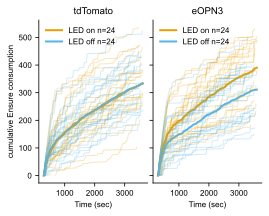

In [14]:

t_led_on_mouse = []
t_led_off_mouse = []


fig, axes = plt.subplots(ncols=2,sharex=True,sharey=True,figsize=[4,3],gridspec_kw={"wspace":0.05})

for plot_idx, virus in enumerate(['0_tdTomato','1_eOPN3']):

    df_select = df_concat[df_concat['virus']==virus]

    i_on = 0
    i_off = 0
    for idx,date in enumerate(df_select['date']):
        if str(date) in LED_on_date_list:
            t = df_select.iloc[idx]['milk pump']
            i_on+=1
        else:
            t = df_select.iloc[idx]['milk pump']
            i_off+=1

    i_on, i_off = 0, 0
    t_led_on, t_led_off = [], []

    # plot average line
    for idx,date in enumerate(df_select['date']):
        if str(date) in LED_on_date_list:
            t_led_on.append(df_select.iloc[idx]['milk pump'])
            i_on+=1
        else:
            t_led_off.append(df_select.iloc[idx]['milk pump'])
            i_off+=1
    if t_led_on !=[]:
        t_led_on_flat = sorted(np.concatenate(t_led_on).ravel())
        axes[plot_idx].plot(t_led_on_flat,np.array(range(1,len(t_led_on_flat)+1))/i_on,c=my_color_map[1],lw=2)
    t_led_off_flat = sorted(np.concatenate(t_led_off).ravel())    
    axes[plot_idx].plot(t_led_off_flat,np.array(range(1,len(t_led_off_flat)+1))/i_off,c=my_color_map[0],lw=2)
    axes[plot_idx].legend([f'LED on n={i_on}',f'LED off n={i_off}'],frameon=False,loc=2)

    # plot individual lines
    for t in t_led_on:
        axes[plot_idx].plot(t,range(1,len(t)+1),c=my_color_map[1],alpha=0.25,lw=1)

    for t in t_led_off:
        axes[plot_idx].plot(t,range(1,len(t)+1),c=my_color_map[0],alpha=0.25,lw=1)

    axes[plot_idx].set_title(f"{virus.split('_')[-1]}")
    axes[plot_idx].set_xlabel('Time (sec)')
    if plot_idx==0:
        axes[plot_idx].set_ylabel('cumulative Ensure consumption')
    sns.despine(ax=axes[plot_idx])
# ax.set_ylim([-10,510])

def save_plot_pdf(plot_name):
    fig_output_folder = '/Users/hunglo/Documents/inscopix_csv/fig_output/'
    kwargs = {"facecolor":"white","dpi":300,"bbox_inches":"tight"}
    # kwargs = {"facecolor":"white","dpi":300} # no tight arg here, to prevent fontsize changes
    plt.savefig(f'{fig_output_folder}{plot_name}.pdf',**kwargs)



plot_name = '6_cumu_ensure_consumption'
save_plot_pdf(plot_name)

In [15]:
## make an eventplot here to just show some example trials

interval = 3 ## sec, defined for when a feeding bout is discontinued and separated into a different feeding bout
LED_on_date_list = ['230106','230110','230112','230114','230117','230120','230221','230223','230225','230228','230302','230304']

file_folder = '/Users/hunglo/Documents/inscopix_csv/opto_csv/csv_folder/' # path where we have all the opto data in csv format
fig_output_folder = '/Users/hunglo/Documents/inscopix_csv/opto_csv/fig_output/'
file_path_list = [f for f in listdir(file_folder) if isfile(join(file_folder, f))]
file_path_list = sorted([f for f in file_path_list if '_.csv' in f])

show_plot = False

for file in file_path_list[9:10]:
    file_path = join(file_folder,file)
    mouse_id, date, LED_state, L1_timestamps_new, Pump1_new, Pump2_new, feeding_epoch, df, baseline_finish_time = return_stats(file_path,LED_on_date_list,interval)

DSC019649
230117
File processed: DSC019649_opto_Inscopix-23.01.17_.csv
Is there any duplication?: False
DSC019649
230117
LED on



/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)


In [16]:

def plot_bout_lick(Pump1_new, Pump2_new, L1_timestamps_new, feeding_epoch, plot_led = False):
    from matplotlib.ticker import FormatStrFormatter

    plt.figure(figsize=[5,2.5])
    trial_num = 0
    total_trial = len(feeding_epoch['start'][2:])
    for idx, timestamp in enumerate(feeding_epoch['start'][2:]):
        if feeding_epoch['end'][2:][idx+2]-timestamp<1:
            continue
        Pump1_select = Pump1_new[Pump1_new>(timestamp-1)]
        Pump2_select = Pump2_new[Pump2_new>(timestamp-1)]
        L1_select = L1_timestamps_new[L1_timestamps_new>(timestamp-0.2)]
        # plt.eventplot([Pump1_select-timestamp],linelengths = [0.4],linewidths = [1], colors='k',lineoffsets = [idx])
        plt.eventplot([L1_select-timestamp],linelengths = [0.4],linewidths = [0.4], colors='k',lineoffsets = [trial_num])
        # plt.plot([0,feeding_epoch['end'][1:][idx+1]-timestamp],[trial_num,trial_num],ls='-',lw=5,color='grey',alpha=0.5,zorder=-100)
        if plot_led:
            plt.plot((Pump2_select-timestamp),np.ones(len(Pump2_select-timestamp))*trial_num,ls='',marker='.',color=my_color_map[3],markersize=4) #,marker='|'

        for x,y in zip(feeding_epoch['start'][2:],feeding_epoch['end'][2:]):
            if y-x>1:
                # plt.plot([x-timestamp,y-timestamp],[trial_num,trial_num],ls='-',lw=int(150/total_trial/1.5),color='grey',alpha=0.5,zorder=-100)
                plt.plot([x-timestamp,y-timestamp],[trial_num,trial_num],ls='-',lw=5,color=[0,0,0.55],zorder=-100,alpha=0.4)
        # for i in range(2):
        #     plt.plot([feeding_epoch['start'][1:0][idx+1+i]-timestamp,feeding_epoch['end'][1:][idx+1+i]-timestamp],[trial_num,trial_num],ls='-',lw=5,color='grey',alpha=0.5,zorder=-100)
        trial_num+=1
    if plot_led:
        plt.legend(['licks','LED','feeding bout'],frameon=False,loc=[1.05,0.35])
        plt.title('eOPN3: Closed-loop LED on')
    else:
        plt.legend(['licks','feeding bout'],frameon=False,loc=[1.05,0.4])
        plt.title('eOPN3: LED off')
        ax = plt.gca()
        # ax.get_legend().remove()

    # plt.axvline(x=0,ls=':',c='k')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.tight_layout()
    plt.xlim([-1,50])
    plt.ylim([-1,trial_num])
    sns.despine()
    # plt.xticks([0,5,10,15,20,25,30])
    plt.ylabel('# of feeding bouts')
    plt.xlabel('Time from feeding onest (second)')

# plot_bout_lick(Pump1_new, Pump2_new, L1_timestamps_new, feeding_epoch, plot_led = True)
# plot_name = '6_LED_on_example'
# save_plot_pdf(plot_name)

DSC019650
230109
File processed: DSC019650_opto_Inscopix-23.01.09_.csv
Is there any duplication?: False
DSC019650
230109
LED off


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC019650_230109
DSC019650
230110
File processed: DSC019650_opto_Inscopix-23.01.10_.csv
Is there any duplication?: False
DSC019650
230110
LED on


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/697697158.py:201: UserWarning: Some epochs have no duration
  feeding_epoch = nap.IntervalSet(feed_start,feed_end)



DSC019650_230110


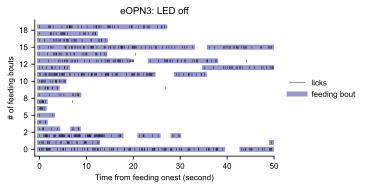

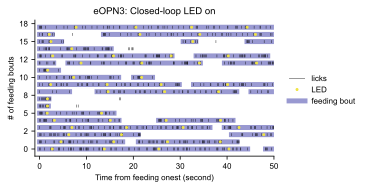

In [17]:
for file in file_path_list[14:16]:
    file_path = join(file_folder,file)
    mouse_id, date, LED_state, L1_timestamps_new, Pump1_new, Pump2_new, feeding_epoch, df, baseline_finish_time = return_stats(file_path,LED_on_date_list,interval)

    if date in LED_on_date_list:
        plot_led = True
        plot_name = '6_LED_on_example'
    else:
        plot_led = False
        plot_name = '6_LED_off_example'

    plot_bout_lick(Pump1_new, Pump2_new, L1_timestamps_new, feeding_epoch, plot_led = plot_led)
    print(f"{mouse_id}_{date}")
    # plt.show()


    save_plot_pdf(plot_name)

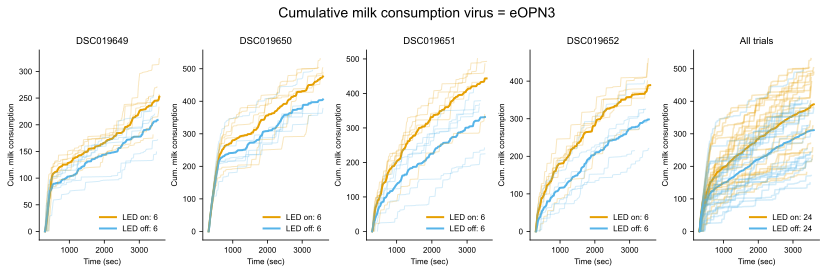

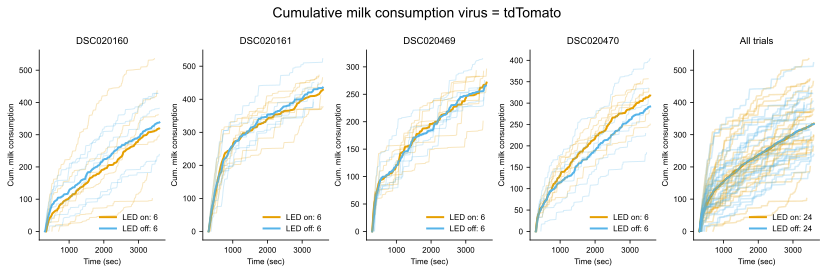

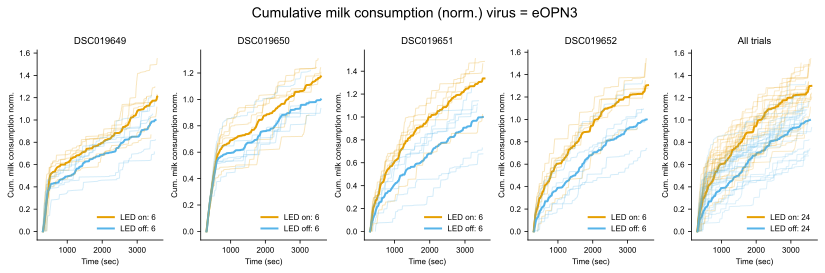

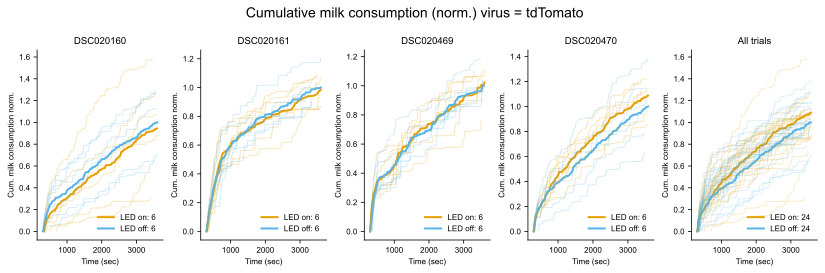

In [18]:
# cumulative plot
virus_types = ['1_eOPN3','0_tdTomato']

for virus_type in virus_types:

    plt.figure(figsize=(14, 3.5))
    plt.subplots_adjust(hspace=0.5,wspace=0.3)

    df_select = df_concat.query("virus==@virus_type")
    plt.suptitle(f"Cumulative milk consumption virus = {virus_type.split('_')[-1]}", fontsize=14, y=1.05)
    cumulative_plots(df_select=df_select,virus_type=virus_type)
    plt.savefig(f"{fig_output_folder}cum_milk_plot_{virus_type.split('_')[-1]}.png",dpi=300,facecolor='w',bbox_inches='tight')


## cumulative plot
virus_types = ['1_eOPN3','0_tdTomato']

for virus_type in virus_types:

    plt.figure(figsize=(14, 3.5))
    plt.subplots_adjust(hspace=0.5,wspace=0.3)

    df_select = df_concat.query("virus==@virus_type")
    plt.suptitle(f"Cumulative milk consumption (norm.) virus = {virus_type.split('_')[-1]}", fontsize=14, y=1.05)
    cumulative_plots_norm(df_select=df_select,virus_type=virus_type)
    plt.savefig(f"{fig_output_folder}cum_milk_plot_{virus_type.split('_')[-1]}_norm.png",dpi=300,facecolor='w',bbox_inches='tight')


In [19]:
def opto_behavior_summary(df_select,virus_type,normalize):
    if normalize:
        df_select = normalize_df(df_select)
    else:
        pass

    ## make a dict of y axis labels
    y_labels = {'milk consumption':'# of pump activations',
                'lick': '# of lick events',
                'feeding duration': 'Seconds',
                'feeding duration after closed-loop trigger': 'Seconds',
                }

    col_names = df_select.columns
    col_names = [col for col in col_names if col not in ['mouse_id','date','LED state','session','milk pump','virus','sex','baseline time']]

    n_mice = len(df_select['mouse_id'].unique())
    n_mice = len(df_select['mouse_id'].unique())
    my_color_map_select = my_color_map[0:n_mice]
    # loop through the length of tickers and keep track of index
    for n, subplot in enumerate(col_names):
        # add a new subplot iteratively
        ax = plt.subplot(1, len(col_names), n + 1)
        sns.lineplot(data=df_select,x='LED state',y=subplot,hue='mouse_id',ci=None,palette=my_color_map_select,ax=ax)
        sns.swarmplot(data=df_select,x='LED state',y=subplot,hue='mouse_id',palette=my_color_map_select,ax=ax,alpha=0.7,size=6)
        sns.despine(ax=ax)

        ax.axvspan(xmin=0.5,xmax=1.5,alpha=0.2,color=my_color_map[3])
        if 'trigger' in subplot:
            ax.set_title('feeding duration after\nclosed-loop trigger')
        else:
            ax.set_title(subplot)
        # plt.ylim(ymin=0)
        if normalize:
            ax.set_ylabel('Normalized')
        else:
            ax.set_ylabel(y_labels[subplot])

        if n == len(col_names)-1: # label the last subplot with legend outside
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),frameon=False)
        else:
            ax.get_legend().remove()
        ax.set_xlim([-0.5,1.5])
    # plt.show()
    ## here are the codes for showing each measures against exp sessions
    ## use mapping here for sns.lineplot

def opto_behavior_summary_session(df_select,virus_type,normalize):
    if normalize:
        df_select = normalize_df(df_select)
    else:
        pass

    ## make a dict of y axis labels
    y_labels = {'milk consumption':'# of pump activations',
                'lick': '# of lick events',
                'feeding duration': 'Seconds',
                'feeding duration after closed-loop trigger': 'Seconds',
                }

    col_names = df_select.columns
    col_names = [col for col in col_names if col not in ['mouse_id','date','LED state','session','milk pump','virus','sex','baseline time']]

    n_mice = len(df_select['mouse_id'].unique())
    n_mice = len(df_select['mouse_id'].unique())
    my_color_map_select = my_color_map[0:n_mice]

    # plt.subplots_adjust(hspace=0.5,wspace=0.5)
    # plt.suptitle("Opto-suppression in aPC upon feeding", fontsize=14, y=1.05)
    # plt.suptitle(f"Opto-suppression in aPC upon feeding virus = {virus_type}", fontsize=14, y=1.05)
    # for subplot in col_names:
    for n, subplot in enumerate(col_names):
        # add a new subplot iteratively
        ax = plt.subplot(1, len(col_names), n + 1)
        sns.pointplot(data=df_select,x='session',y=subplot,palette=my_color_map_select,hue='mouse_id')
        sns.despine()
        session_num = df_select['session'].max()
        for i in range(session_num//2):
            ax.axvspan(xmin=i*2+0.5,xmax=i*2+1.5,alpha=0.2,color=my_color_map[3])
        if 'trigger' in subplot:
            ax.set_title('feeding duration after\nclosed-loop trigger')
        else:
            ax.set_title(subplot)

        if normalize:
            ax.set_ylabel('Normalized')
        else:
            ax.set_ylabel(y_labels[subplot])

        # plt.ylim(ymin=0)
        plt.xlim(xmin=-0.5)
        if n == len(col_names)-1: # label the last subplot with legend outside
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),frameon=False)
        else:
            ax.get_legend().remove()

def normalize_df(df_concat):
    col_names = df_concat.columns
    col_names = [col for col in col_names if col not in ['mouse_id','date','LED state','session','milk pump','virus','sex']]

    n_mice = len(df_concat['mouse_id'].unique())

    df_concat_norm = df_concat.copy()
    for mouse_id in df_concat['mouse_id'].unique():
        sub_df = df_concat[(df_concat['LED state']=='LED off') & (df_concat['mouse_id']==mouse_id)]
        for col_idx,sub_col in enumerate(col_names):
            mean_value = sub_df[sub_col].mean()
            # mean_value = sub_df[sub_col].median()
            df_concat_norm.loc[df_concat_norm['mouse_id']==mouse_id,sub_col] = df_concat_norm.loc[df_concat_norm['mouse_id']==mouse_id,sub_col]/mean_value

    ## rename columns ## currently disabled, it's easier to handle with same column names for later analysis
    # keep_same = {'mouse_id', 'date','LED state','session','milk pump','virus','lick'}
    # df_concat_norm.columns = [f"{c}{'' if c in keep_same else ' (norm.)'}" for c in df_concat_norm.columns]

    return df_concat_norm



/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/3294867448.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_select,x='LED state',y=subplot,hue='mouse_id',ci=None,palette=my_color_map_select,ax=ax)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/3294867448.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_select,x='LED state',y=subplot,hue='mouse_id',ci=None,palette=my_color_map_select,ax=ax)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/3294867448.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_select,x='LED state',y=subplot,hue='mouse_id',ci=None,palette=my_color_map_select,ax=ax)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_92529/3294867448.py:24: FutureWarning: 

The `ci` parameter is deprecated. Us

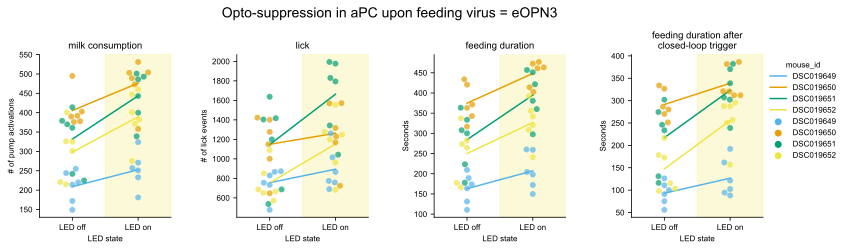

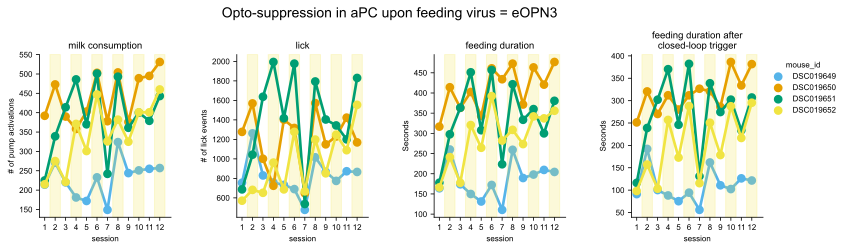

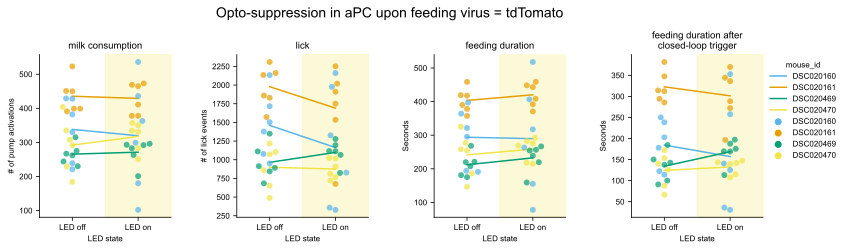

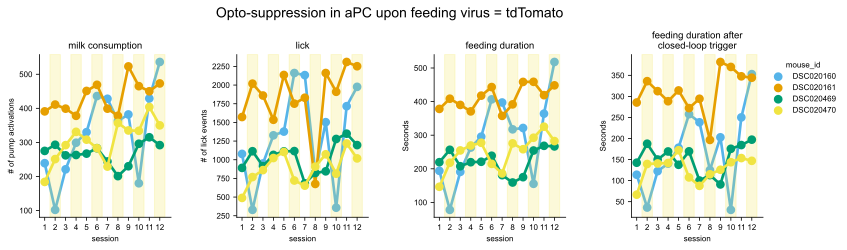

In [20]:
## plot behavior summary, with or without normalization to baseline (LED off state)

virus_types = df_concat['virus'].unique()
normalize = 0
figsize=(13, 3)

for virus_type in virus_types:

    plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    df_select = df_concat.query("virus==@virus_type")
    plt.suptitle(f"Opto-suppression in aPC upon feeding virus = {virus_type.split('_')[-1]}", fontsize=14, y=1.1)
    opto_behavior_summary(df_select,virus_type,normalize=normalize)
    plt.savefig(f"{fig_output_folder}opto_summary_plot_{virus_type.split('_')[-1]}.png",dpi=300,facecolor='w',bbox_inches='tight')

    plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    df_select = df_concat.query("virus==@virus_type")
    plt.suptitle(f"Opto-suppression in aPC upon feeding virus = {virus_type.split('_')[-1]}", fontsize=14, y=1.1)
    opto_behavior_summary_session(df_select,virus_type,normalize=normalize)
    plt.savefig(f"{fig_output_folder}opto_session_plot_{virus_type.split('_')[-1]}.png",dpi=300,facecolor='w',bbox_inches='tight')
    


In [21]:
## save df to csv for stats in R

## first add body weight data to the dataframe
df_weight = pd.read_csv('/Users/hunglo/Documents/inscopix_csv/opto_csv/opto_weight.csv').sort_values(by=['mouse_id','date'], ascending=True).dropna()
df_concat_2 = pd.merge(df_concat, df_weight, how="outer", on=['mouse_id','date']).sort_values(by=['mouse_id','date'], ascending=True)
df_concat_2.to_csv('/Users/hunglo/Documents/inscopix_csv/opto_csv/processed_csv/opto_data.csv',index=False)

df_norm = normalize_df(df_concat=df_concat_2)
df_norm.to_csv('/Users/hunglo/Documents/inscopix_csv/opto_csv/processed_csv/opto_data_norm.csv',index=False)

df_concat_2


mouse_id    date LED state milk consumption  lick feeding duration  \
0   DSC019649  230105   LED off              214   755       164.054032   
1   DSC019649  230106    LED on              271  1262       260.096987   
2   DSC019649  230109   LED off              220   830       173.890025   
3   DSC019649  230110    LED on              181   758       149.920997   
4   DSC019649  230111   LED off              172   733       131.353023   
..        ...     ...       ...              ...   ...              ...   
91  DSC020470  230228    LED on              357   908       275.668014   
92  DSC020470  230301   LED off              335  1073       258.244987   
93  DSC020470  230302    LED on              334   813       292.427031   
94  DSC020470  230303   LED off              404  1218       325.331962   
95  DSC020470  230304    LED on              350  1018       282.488027   

   feeding duration after closed-loop trigger  \
0                                   91.096995   
1                                  192.120992   
2                                  100.188007   
3                                    88.11199   
4                                   75.277018   
..                                        ...   
91                                    114.975   
92                                 125.825026   
93                                 143.680002   
94                                 153.567972   
95                                 147.030004   

                                            milk pump baseline time  session  \
0   [302.402997, 302.999996, 303.621998, 304.75999...     15.219997        1   
1   [387.398004, 388.235004, 389.295003, 390.17599...    100.184997        2   
2   [373.028, 374.535006, 375.413003, 375.935999, ...     87.383006        3   
3   [414.099, 415.137001, 415.952997, 416.565996, ...    130.054997        4   
4   [345.604, 346.320999, 347.030999, 348.252998, ...     60.850999        5   
..                                                ...           ...      ...   
91  [307.485003, 309.332001, 310.173002, 310.83300...     23.881002        8   
92  [317.191999, 318.278004, 319.088998, 320.139, ...     34.247999        9   
93  [304.458998, 305.444002, 306.254995, 307.05399...     19.364001       10   
94  [302.952001, 304.358006, 305.088008, 306.47900...     21.376006       11   
95  [303.018002, 304.124, 304.773002, 305.445004, ...     23.323005       12   

         virus     sex  bodyweight  
0      1_eOPN3    Male       28.51  
1      1_eOPN3    Male       28.04  
2      1_eOPN3    Male       28.42  
3      1_eOPN3    Male       28.24  
4      1_eOPN3    Male       27.97  
..         ...     ...         ...  
91  0_tdTomato  Female       22.36  
92  0_tdTomato  Female       22.34  
93  0_tdTomato  Female       22.02  
94  0_tdTomato  Female       22.15  
95  0_tdTomato  Female       22.49  

[96 rows x 13 columns]